In [1]:
import pandas as pd
from sklearn import preprocessing
from neupy import environment
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from neupy import environment
from neupy import algorithms, layers
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

%matplotlib inline

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
G:\anaconda\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


#### Select original the training records for discovery

In [2]:
train_df = pd.read_csv("original_data/train_70.0.csv")
target_training = train_df.loc[:," shares"]

#### Data discovery - relation between no of shares and the day of the week

In [3]:
day_of_week_columns = [" weekday_is_monday", " weekday_is_tuesday", " weekday_is_wednesday"," weekday_is_thursday"," weekday_is_friday"," weekday_is_saturday", " weekday_is_sunday"]
share_by_weekday = [0]*len(day_of_week_columns)
print(train_df.shape)
for idx, row in train_df.iterrows():
    for day_no, day_of_week_column in enumerate(day_of_week_columns):
        if row[day_of_week_column] == 1:
            share_by_weekday[day_no] += row[" shares"]
            
print(share_by_weekday)

(27750, 62)
[16965029, 16083831, 16835516, 15912807, 13505688, 7176474, 7130078]


Text(0.5,1,'Distribution of shares by day of week')

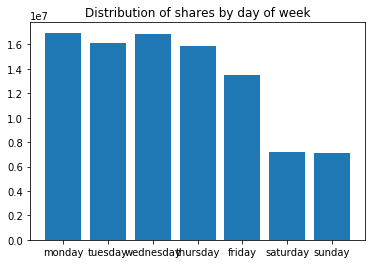

In [4]:
weekday_names = [day_of_week_column.replace(" weekday_is_", "") for day_of_week_column in day_of_week_columns]
plt.bar(weekday_names, share_by_weekday)
plt.title("Distribution of shares by day of week")

[5592887, 14892053, 12889454, 6144253, 16071719, 13340303]


Text(0.5,1,'Distribution of shares by channel')

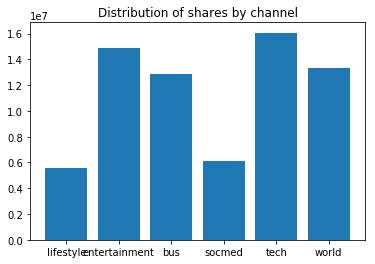

In [5]:
data_channel_columns = [" data_channel_is_lifestyle", " data_channel_is_entertainment", " data_channel_is_bus", " data_channel_is_socmed", " data_channel_is_tech", " data_channel_is_world"]
share_by_channel = [0]*len(data_channel_columns)

for idx, row in train_df.iterrows():
    for day_no, data_channel_column in enumerate(data_channel_columns):
        if row[data_channel_column] == 1:
            share_by_channel[day_no] += row[" shares"]
            
print(share_by_channel)

channel_names = [data_channel_column.replace(" data_channel_is_", "") for data_channel_column in data_channel_columns]
plt.bar(channel_names, share_by_channel)
plt.title("Distribution of shares by channel")

## Train a Multi-Layer Feedforward Neural Network using Scikit-Learn

### Load the data after removing some columns (refer to report for exact steps carried out)

In [21]:
training_df = pd.read_csv("data_with_fields_removed/train_70.0_updated.csv")
training_X = training_df.loc[:, training_df.columns != " shares"]
training_Y = training_df.loc[:, " shares"]

test_df = pd.read_csv("data_with_fields_removed/test_30.0_updated.csv")
testing_X = test_df.loc[:, test_df.columns != " shares"]
testing_Y = test_df.loc[:, " shares"]

print("Training shapes")
print(training_X.shape)
print(training_Y.shape)

print("Testing shapes")
print(testing_X.shape)
print(testing_Y.shape)

Training shapes
(27750, 27)
(27750,)
Testing shapes
(11894, 27)
(11894,)


### Transform the data

In [22]:
x_data_scaler = preprocessing.MinMaxScaler()
y_data_scaler = preprocessing.MinMaxScaler()

columns_to_scale = [" n_tokens_title", " n_tokens_content", " num_hrefs", " num_self_hrefs", " num_imgs", " num_videos", " average_token_length", " num_keywords", " kw_avg_min"," kw_avg_max", " kw_avg_avg"," self_reference_avg_sharess"]

x_data_scaler.fit(training_X.loc[:, columns_to_scale])
y_data_scaler.fit(training_Y.reshape(-1, 1))

training_X.loc[:, columns_to_scale] = x_data_scaler.transform(training_X.loc[:, columns_to_scale])
training_Y = y_data_scaler.transform(training_Y.reshape(-1, 1))

testing_X.loc[:, columns_to_scale] = x_data_scaler.transform(testing_X.loc[:, columns_to_scale])
testing_Y = y_data_scaler.transform(testing_Y.reshape(-1, 1))

G:\anaconda\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  import sys
G:\anaconda\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
G:\anaconda\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
G:\anaconda\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  # Remove the CWD from sys.path while we load stuff.
G:\anaconda\lib\site-packages\ipykern

In [8]:
print(training_Y)
print(testing_Y)

[[ 0.00550262]
 [ 0.00217121]
 [ 0.00140933]
 ..., 
 [ 0.00159183]
 [ 0.00217121]
 [ 0.00119931]]
[[ 0.00419902]
 [ 0.00188152]
 [ 0.0256359 ]
 ..., 
 [ 0.00173668]
 [ 0.00077781]
 [ 0.00275058]]


In [9]:
print(training_X.head())
print(testing_X.head())

    n_tokens_title   n_tokens_content   n_unique_tokens  \
0         0.333333           0.103549          0.497970   
1         0.476190           0.086708          0.503268   
2         0.571429           0.068615          0.582485   
3         0.380952           0.017537          0.821138   
4         0.428571           0.033125          0.608696   

    n_non_stop_unique_tokens   num_hrefs   num_self_hrefs   num_imgs  \
0                   0.689655    0.029605         0.000000   0.000000   
1                   0.675603    0.016447         0.034483   0.070312   
2                   0.777778    0.029605         0.000000   0.007812   
3                   0.892857    0.013158         0.025862   0.000000   
4                   0.773050    0.016447         0.025862   0.007812   

    num_videos   average_token_length   num_keywords  \
0     0.010989               0.580320       0.555556   
1     0.000000               0.586442       0.666667   
2     0.000000               0.580405       

In [10]:
print(training_X.shape)
print(testing_X.shape)

(27750, 27)
(11894, 27)


In [13]:
from sklearn.neural_network import MLPRegressor
from scipy import stats
from sklearn.grid_search import RandomizedSearchCV
from neupy import estimators

mlp = MLPRegressor(hidden_layer_sizes=(10, 10, 10), max_iter=500)
mlp.fit(training_X, training_Y)
y_predicted = mlp.predict(testing_X)
print("RMSE = " + str(estimators.rmse(y_predicted, testing_Y.ravel())))
print("MAE = " + str(estimators.mae(y_predicted, testing_Y.ravel())))
actual_mae = y_data_scaler.inverse_transform(estimators.mae(y_predicted, testing_Y.ravel()))
print("MAE (no. of shares) = " + str(actual_mae.squeeze()))

/Users/pierlim/anaconda/envs/tensorflow/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/pierlim/anaconda/envs/tensorflow/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/Users/pierlim/anaconda/envs/tensorflow/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:1306: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the sh

RMSE = 0.020877109870924986
MAE = 0.008458446876731775
MAE (no. of shares) = 5840.7032652487405


### Randomized Search to Find the Best Hyper-Parameters

In [16]:

# Randomized search uses 3-fold cross validation by default
rs = RandomizedSearchCV(mlp, param_distributions={
    'learning_rate': ["constant", "invscaling", "adaptive"],
    'hidden_layer_sizes': [(100, 10, 10), (100, 50, 25), (1000, 50, 50)],
    'learning_rate_init': stats.uniform(0.001, 0.05),
    'solver': ["sgd", "adam", "lbfgs"],
    'activation': ["relu", "tanh"],
    'alpha': stats.uniform(0.0001, 1),
    'beta_1': stats.uniform(0, 1.0),
    'beta_2': stats.uniform(0, 1.0)}, verbose=2, scoring="neg_mean_absolute_error")

rs.fit(training_X, training_Y.ravel())
bs = rs.best_estimator_

y_predicted = bs.predict(testing_X)
print("RMSE = " + str(estimators.rmse(y_predicted, testing_Y.ravel())))
print("MAE = " + str(estimators.mae(y_predicted, testing_Y.ravel())))
actual_mae = y_data_scaler.inverse_transform(estimators.mae(y_predicted, testing_Y))
print("MAE (no. of shares) = " + str(actual_mae.squeeze()))


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] activation=tanh, alpha=0.508028273322, beta_1=0.198107594993, beta_2=0.035421200098, hidden_layer_sizes=(1000, 50, 50), learning_rate=adaptive, learning_rate_init=0.0036126429172, solver=adam 
[CV]  activation=tanh, alpha=0.508028273322, beta_1=0.198107594993, beta_2=0.035421200098, hidden_layer_sizes=(1000, 50, 50), learning_rate=adaptive, learning_rate_init=0.0036126429172, solver=adam -   4.1s
[CV] activation=tanh, alpha=0.508028273322, beta_1=0.198107594993, beta_2=0.035421200098, hidden_layer_sizes=(1000, 50, 50), learning_rate=adaptive, learning_rate_init=0.0036126429172, solver=adam 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.1s remaining:    0.0s


[CV]  activation=tanh, alpha=0.508028273322, beta_1=0.198107594993, beta_2=0.035421200098, hidden_layer_sizes=(1000, 50, 50), learning_rate=adaptive, learning_rate_init=0.0036126429172, solver=adam -   4.1s
[CV] activation=tanh, alpha=0.508028273322, beta_1=0.198107594993, beta_2=0.035421200098, hidden_layer_sizes=(1000, 50, 50), learning_rate=adaptive, learning_rate_init=0.0036126429172, solver=adam 
[CV]  activation=tanh, alpha=0.508028273322, beta_1=0.198107594993, beta_2=0.035421200098, hidden_layer_sizes=(1000, 50, 50), learning_rate=adaptive, learning_rate_init=0.0036126429172, solver=adam -   3.6s
[CV] activation=tanh, alpha=0.053108096811, beta_1=0.100376859966, beta_2=0.820674467073, hidden_layer_sizes=(100, 10, 10), learning_rate=constant, learning_rate_init=0.0158993802978, solver=adam 
[CV]  activation=tanh, alpha=0.053108096811, beta_1=0.100376859966, beta_2=0.820674467073, hidden_layer_sizes=(100, 10, 10), learning_rate=constant, learning_rate_init=0.0158993802978, solver

[CV]  activation=relu, alpha=0.218034248401, beta_1=0.808824025374, beta_2=0.36322518834, hidden_layer_sizes=(100, 50, 25), learning_rate=invscaling, learning_rate_init=0.0315352470997, solver=lbfgs -   6.0s
[CV] activation=relu, alpha=0.218034248401, beta_1=0.808824025374, beta_2=0.36322518834, hidden_layer_sizes=(100, 50, 25), learning_rate=invscaling, learning_rate_init=0.0315352470997, solver=lbfgs 
[CV]  activation=relu, alpha=0.218034248401, beta_1=0.808824025374, beta_2=0.36322518834, hidden_layer_sizes=(100, 50, 25), learning_rate=invscaling, learning_rate_init=0.0315352470997, solver=lbfgs -   0.8s
[CV] activation=tanh, alpha=0.7527363189, beta_1=0.617867222764, beta_2=0.873252749903, hidden_layer_sizes=(100, 50, 25), learning_rate=constant, learning_rate_init=0.0421522195101, solver=adam 
[CV]  activation=tanh, alpha=0.7527363189, beta_1=0.617867222764, beta_2=0.873252749903, hidden_layer_sizes=(100, 50, 25), learning_rate=constant, learning_rate_init=0.0421522195101, solver=

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 14.0min finished


RMSE = 0.019006963449509844
MAE = 0.0046700558447806805
MAE (no. of shares) = 3225.2018851807375


### Plot the loss curve

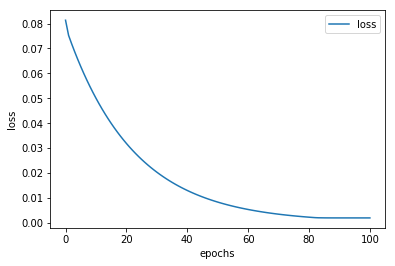

In [17]:
# plot the loss curve
import matplotlib.pyplot as plt

df = pd.DataFrame(bs.loss_curve_)
df.columns = ['loss']
ax = df.plot()
ax.set_xlabel('epochs')
ax.set_ylabel('loss')
plt.show()

### Save the Best Model from the Randomized Search

In [ ]:
# Save the best MLP model
import _pickle
with open('/home/pier/Machine_Learning/KE5206NN/regression/regression_models/best_model.pkl', 'wb') as fid:
    _pickle.dump(bs, fid)

## GRNN using Neupy

### NeuPy imports

In [14]:
from neupy import algorithms, layers, estimators

environment.reproducible()

### Grid-Search Get the MAE for different values of STD

In [17]:
std_values = [0.1 + 0.1 * x for x in range(5)]
mae_training = []
mae_testing = []
for std_value in std_values:
    nw = algorithms.GRNN(std=std_value, verbose=True)
    nw.train(training_X, training_Y)
    testing_Y_predicted = nw.predict(testing_X)
    mae_testing.append(estimators.mae(testing_Y_predicted, testing_Y))



Main information

[ALGORITHM] GRNN

[OPTION] verbose = True
[OPTION] epoch_end_signal = None
[OPTION] show_epoch = 1
[OPTION] shuffle_data = False
[OPTION] step = 0.1
[OPTION] train_end_signal = None
[OPTION] std = 0.1


Main information

[ALGORITHM] GRNN

[OPTION] verbose = True
[OPTION] epoch_end_signal = None
[OPTION] show_epoch = 1
[OPTION] shuffle_data = False
[OPTION] step = 0.1
[OPTION] train_end_signal = None
[OPTION] std = 0.2


Main information

[ALGORITHM] GRNN

[OPTION] verbose = True
[OPTION] epoch_end_signal = None
[OPTION] show_epoch = 1
[OPTION] shuffle_data = False
[OPTION] step = 0.1
[OPTION] train_end_signal = None
[OPTION] std = 0.30000000000000004


Main information

[ALGORITHM] GRNN

[OPTION] verbose = True
[OPTION] epoch_end_signal = None
[OPTION] show_epoch = 1
[OPTION] shuffle_data = False
[OPTION] step = 0.1
[OPTION] train_end_signal = None
[OPTION] std = 0.4


Main information

[ALGORITHM] GRNN

[OPTION] verbose = True
[OPTION] epoch_end_signal = None
[OPTIO

#### Generate the validation curves

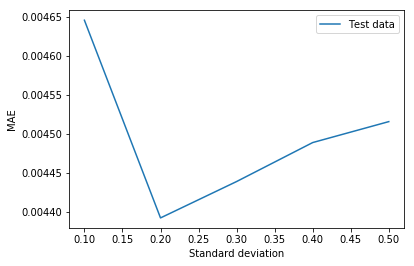

In [20]:
def generate_rmse_curves_testing_training_data(hyperparameter_values, validation_rmse, training_rmse, title_text, x_label_text):
    plt.figure()
    plt.xlabel(x_label_text)
    plt.ylabel("MAE")
    plt.plot(hyperparameter_values, validation_rmse)
    plt.legend(['Test data'])
    
generate_rmse_curves_testing_training_data(std_values, mae_testing, mae_training, "MAE with standard deviation", "Standard deviation")

#### Check the MAE for the best candidate Standard deviation

In [15]:
nw = algorithms.GRNN(std=0.2, verbose=False)
nw.train(training_X, training_Y)
y_predicted = nw.predict(testing_X)
print(estimators.mae(y_predicted, testing_Y))

0.004392001101080488


### Invert the target values using [this](https://stackoverflow.com/questions/41551165/invert-minmaxscaler-from-scikit-learn)

In [12]:
y_predicted_upscaled = y_data_scaler.inverse_transform(y_predicted)
testing_Y_upscaled = y_data_scaler.inverse_transform(testing_Y)

### Check the predicted values

In [12]:
slice = 100
for itr in range(slice):
    print("#{0}. Diff={1}".format(itr, abs(y_predicted_upscaled[itr] - testing_Y_upscaled[itr])))

#0. Diff=[1290.89548681]
#1. Diff=[944.15984776]
#2. Diff=[16071.0015258]
#3. Diff=[514.39948712]
#4. Diff=[15838.6004488]
#5. Diff=[1154.60599213]
#6. Diff=[3647.21293788]
#7. Diff=[295.10553786]
#8. Diff=[383.55702558]
#9. Diff=[2279.62215478]
#10. Diff=[3493.67788242]
#11. Diff=[3999.95134365]
#12. Diff=[16309.93409339]
#13. Diff=[4580.0040625]
#14. Diff=[1371.68037944]
#15. Diff=[1740.82161519]
#16. Diff=[4229.96199357]
#17. Diff=[560.27674053]
#18. Diff=[1978.80975366]
#19. Diff=[838.72333133]
#20. Diff=[133309.33855459]
#21. Diff=[2008.25303324]
#22. Diff=[2688.78363661]
#23. Diff=[1516.74625832]
#24. Diff=[3699.99755283]
#25. Diff=[2187.78783993]
#26. Diff=[1379.57390628]
#27. Diff=[230.60273462]
#28. Diff=[1214.53274272]
#29. Diff=[817.56162325]
#30. Diff=[2238.60482879]
#31. Diff=[1835.76871171]
#32. Diff=[349.61808355]
#33. Diff=[1641.44742993]
#34. Diff=[101.90641847]
#35. Diff=[73.87574518]
#36. Diff=[1751.02214333]
#37. Diff=[403.23643598]
#38. Diff=[3454.66326129]
#39. Di

### Save the Best GRNN Model

In [ ]:
# Save the best GRNN model
import _pickle
with open('./regression_models/grnn_best.pkl', 'wb') as fid:
    _pickle.dump(nw, fid)

### SOM using [Neupy](http://neupy.com/apidocs/neupy.algorithms.competitive.sofm.html)

In [23]:
num_epochs = 20
num_clusters = [3, 4, 5]
pca_components = 2

#### Perform PCA on the input data to get 2 components to visualize the data

In [24]:
pca = PCA(n_components=pca_components)
pca_X = pca.fit_transform(training_X)
num_features = pca_components

In [25]:
print(pca.explained_variance_)
print(pca.explained_variance_ratio_)

[32.91615358  0.11551647]
[0.98364524 0.00345202]


In [26]:
# n_inputs is the number of features
sofms = []

for num_cluster in num_clusters:
    print("Number of clusters: " + str(num_cluster))
    sofm = algorithms.SOFM(n_inputs=pca_components, n_outputs=num_cluster, step=0.1, learning_radius=0, verbose=True, grid_type='rect')
    sofm.train(pca_X, epochs=num_epochs)
    sofms.append(sofm)


Number of clusters: 3

Main information

[ALGORITHM] SOFM

[OPTION] verbose = True
[OPTION] epoch_end_signal = None
[OPTION] show_epoch = 1
[OPTION] shuffle_data = False
[OPTION] step = 0.1
[OPTION] train_end_signal = None
[OPTION] n_inputs = 2
[OPTION] distance = euclid
[OPTION] features_grid = None
[OPTION] grid_type = rect
[OPTION] learning_radius = 0
[OPTION] n_outputs = 3
[OPTION] reduce_radius_after = 100
[OPTION] reduce_std_after = 100
[OPTION] reduce_step_after = 100
[OPTION] std = 1
[OPTION] weight = Normal(mean=0, std=0.01)


Start training

[TRAINING DATA] shapes: (27750, 2)
[TRAINING] Total epochs: 20

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
---------------------------------------------------------
|           1 |     0.10523 |           - |       6 sec |
|           2 |      0.1212 |           - |       6 sec |
|           3 |      0.1123 |           - |       6 sec |
|           4 |      0.1109 | 

#### Print the SOM cluster centres after the training for different number of clusters

In [27]:
for sofm in sofms:
    print(sofm.weight.T.shape)
    print(sofm.weight.T)

(3, 2)
[[ 4.50046453e-02 -1.30210508e-01]
 [-3.79858335e-02  8.62940532e-01]
 [ 8.12664691e+02  1.42819204e-01]]
(4, 2)
[[-8.79275607e-01 -1.99037674e-01]
 [ 8.12669177e+02 -2.99833260e-03]
 [ 4.76469373e-02 -1.30117279e-01]
 [-3.79858335e-02  8.62940532e-01]]
(5, 2)
[[ 1.71086752e-01 -1.22087794e-01]
 [-1.12752500e-01 -1.37055909e-01]
 [ 8.12668559e+02 -3.47401098e-03]
 [-8.79817139e-01 -1.99173285e-01]
 [-3.79858335e-02  8.62940532e-01]]


In [28]:
def get_values_from_column(values, column_index):
    return [value[column_index] for value in values]

#### Plot the cluster centres for different number of clusters

3
4
5


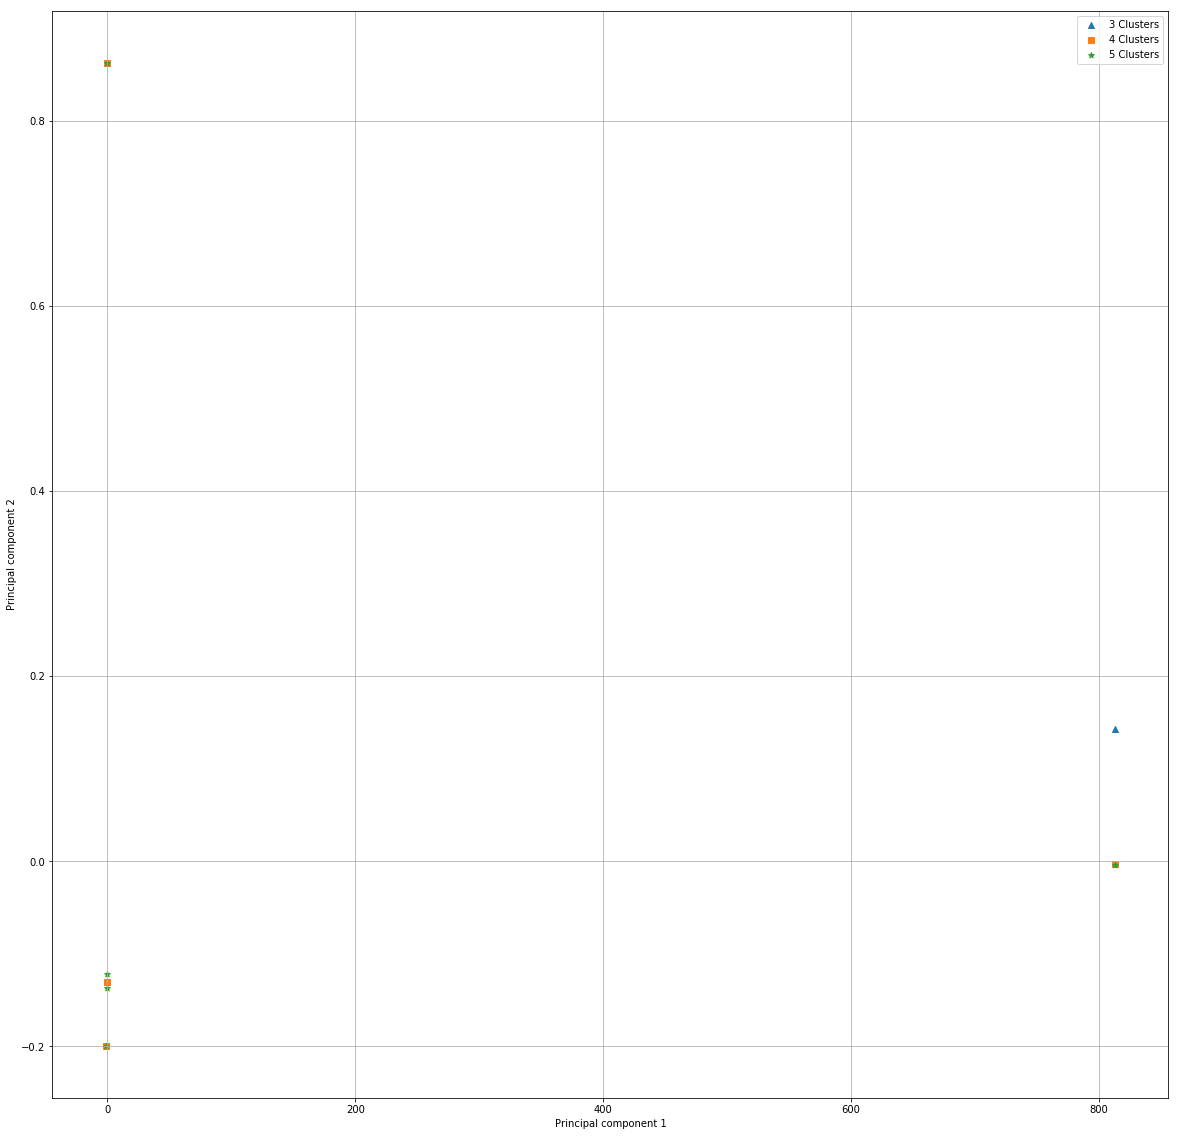

In [36]:
plt.rcParams['figure.figsize'] = (20, 20)
fig, ax = plt.subplots()

print(len(get_values_from_column(sofms[0].weight.T, 0)))
print(len(get_values_from_column(sofms[1].weight.T, 0)))
print(len(get_values_from_column(sofms[2].weight.T, 0)))


ax.scatter(get_values_from_column(sofms[0].weight.T, 0), get_values_from_column(sofms[0].weight.T, 1), marker='^', label = "3 Clusters")
ax.scatter(get_values_from_column(sofms[1].weight.T, 0), get_values_from_column(sofms[1].weight.T, 1), marker='s', label = "4 Clusters")
ax.scatter(get_values_from_column(sofms[2].weight.T, 0), get_values_from_column(sofms[2].weight.T, 1), marker='*', label = "5 Clusters")

plt.xlabel("Principal component 1")
plt.ylabel("Principal component 2")
ax.legend()
ax.grid(True)

### Plot all the training sample for 5 clusters

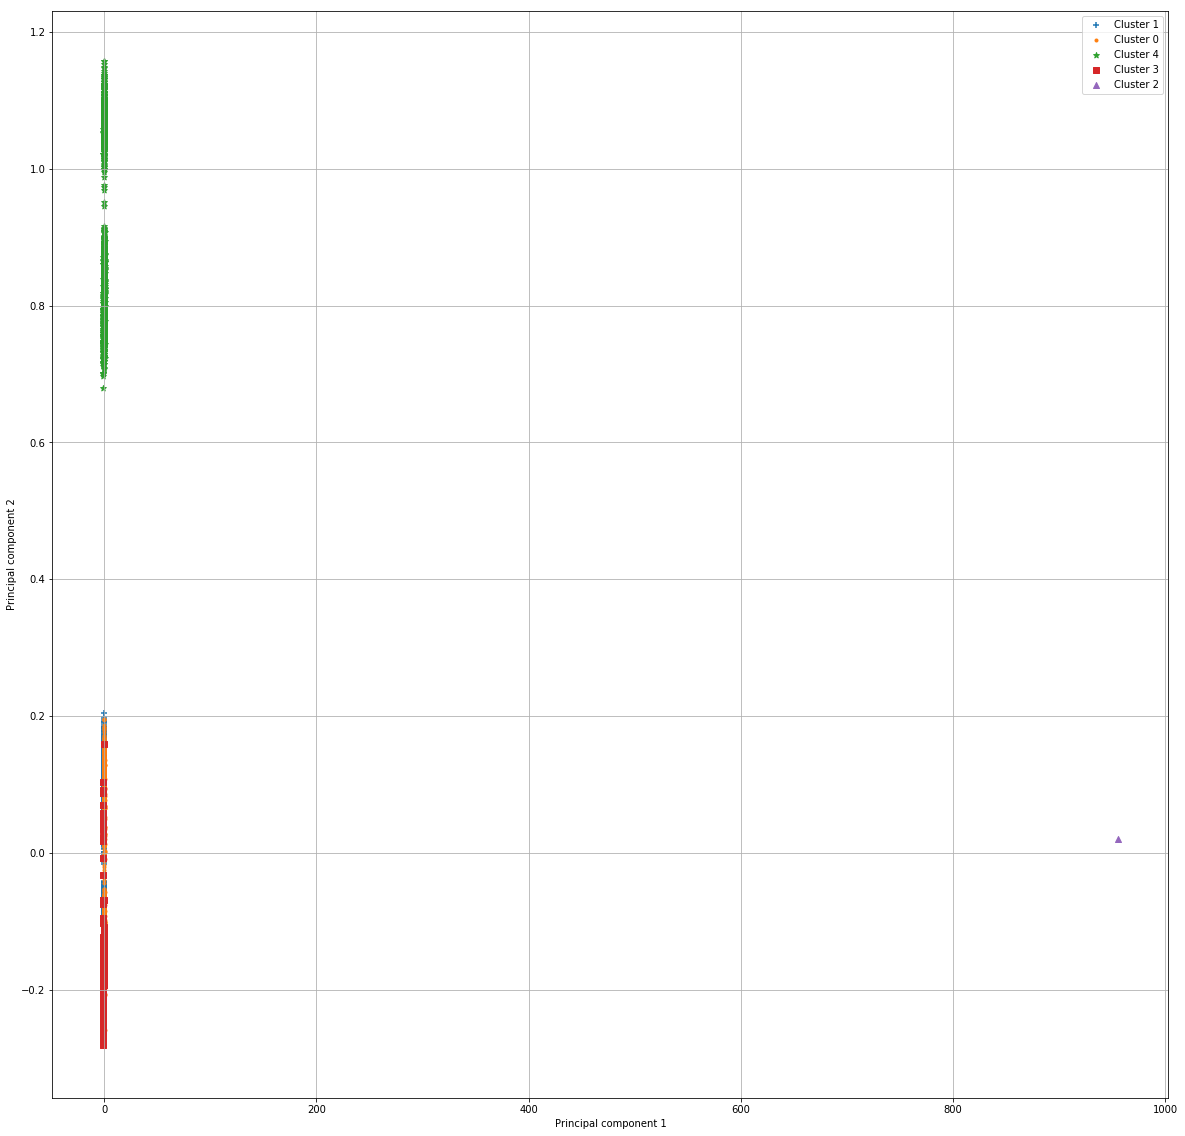

In [39]:
pca_training_predictions = sofms[2].predict(pca_X)
cluster_points = {}
for idx, prediction in enumerate(pca_training_predictions):
    predicted_label = np.argmax(prediction)
    if cluster_points.get(predicted_label):
        cluster_points[predicted_label].append((pca_X[idx][0], pca_X[idx][1]))
    else:
        cluster_points[predicted_label] = [(pca_X[idx][0], pca_X[idx][1])]
        
#print(cluster_points)
#ax.scatter(get_values_from_column(pca_X, 0), get_values_from_column(pca_X, 1))
markers = [".", "+", "^", "s", "*"]
fig, ax = plt.subplots()
for cluster_label in cluster_points:
    ax.scatter(get_values_from_column(cluster_points[cluster_label], 0), get_values_from_column(cluster_points[cluster_label], 1), marker=markers[int(cluster_label)], label = "Cluster " + str(cluster_label))


plt.xlabel("Principal component 1")
plt.ylabel("Principal component 2")
ax.legend()
ax.grid(True)

#### Get the predictions for the training set and then get the average of the number of shares for the clusters

In [25]:
trainingX_predictions = sofm.predict(training_X)
cluster_sums = np.zeros(num_clusters)
cluster_counts = np.zeros(num_clusters)
for idx, prediction in enumerate(trainingX_predictions):
    predicted_label = np.argmax(prediction)
    cluster_sums[predicted_label] += training_Y[idx]
    cluster_counts[predicted_label] += 1

#print(cluster_counts)
cluster_averages = cluster_sums/(1+cluster_counts)
print(cluster_averages)

[0.         0.         0.         0.         0.00481474 0.
 0.         0.00712548 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00427217 0.         0.         0.         0.        ]


#### Get the predictions for the test data

In [28]:
testing_X_predictions = sofm.predict(testing_X)
abs_error = 0
predicted_values = []

for idx, prediction in enumerate(testing_X_predictions):
    predicted_label = np.argmax(prediction)
    predicted_shares = cluster_averages[predicted_label]
    predicted_values.append(predicted_shares)
    actual_shares = testing_Y[idx]
    abs_error += abs(predicted_shares-actual_shares)

mae = abs_error/len(testing_X)
print("MAE: " + str(mae))

MAE: [0.00470036]


In [45]:
print_abs_difference_of_predictions(data_scaler, testing_Y, np.array(predicted_values).reshape(-1, 1), 30)

(11894, 1)
(11894, 1)
#0. Diff=[1168.23154819]
#1. Diff=[2768.23154819]
#2. Diff=[13631.76845181]
#3. Diff=[2568.23154819]
#4. Diff=[2668.23154819]
#5. Diff=[1168.23154819]
#6. Diff=[3267.23154819]
#7. Diff=[1068.23154819]
#8. Diff=[3068.23154819]
#9. Diff=[3701.23154819]
#10. Diff=[631.76845181]
#11. Diff=[2368.23154819]
#12. Diff=[13731.76845181]
#13. Diff=[13731.76845181]
#14. Diff=[3184.23154819]
#15. Diff=[2568.23154819]
#16. Diff=[3331.76845181]
#17. Diff=[2868.23154819]
#18. Diff=[3455.23154819]
#19. Diff=[3304.23154819]
#20. Diff=[3086.23154819]
#21. Diff=[68.23154819]
#22. Diff=[2168.23154819]
#23. Diff=[468.23154819]
#24. Diff=[4916.85674041]
#25. Diff=[3888.23154819]
#26. Diff=[3543.23154819]
#27. Diff=[2868.23154819]
#28. Diff=[668.23154819]
#29. Diff=[3356.23154819]
